Installing necessary libraries...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Installation complete.
Cleaning Kaggle working directory: /kaggle/working
Kaggle working directory cleaned!
Using device: cuda

[INFO] Loading and preprocessing data for English -> Romanized Chakma...
Dataset loaded with 808 samples after cleaning.

[INFO] Splitting the dataset...
Train: 565, Validation: 81, Test: 162

[INFO] Initializing model and tokenizer...

[INFO] Tokenizing datasets...


Map:   0%|          | 0/565 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]


[INFO] Setting up evaluation metrics (BLEU, METEOR, BERTScore)...


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



[INFO] Configuring training arguments...


/tmp/ipykernel_36/960573947.py:219: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(



[INFO] Starting model training...


Epoch,Training Loss,Validation Loss,Bleu,Meteor,Bertscore F1,Gen Len
1,6.786600,4.744671,0.411400,0.063800,0.784000,20.604900
2,3.702100,3.494254,2.609700,0.193000,0.849200,14.160500
3,2.344500,3.116289,7.760300,0.251200,0.860100,13.740700
4,1.409900,3.077744,7.174400,0.272600,0.866400,13.864200
5,0.736100,3.407930,6.406300,0.295300,0.861700,16.370400
6,0.362800,3.606646,8.461700,0.279100,0.866600,13.629600
7,0.234700,3.574626,9.837700,0.305200,0.869800,14.086400
8,0.166100,3.602105,8.647600,0.283600,0.867400,12.802500
9,0.118600,3.691586,10.262300,0.300800,0.867400,13.407400
10,0.097800,3.697786,10.786600,0.281100,0.865800,12.839500


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



[INFO] Training finished.
Best model saved to ./mbart-eng-to-romanized-chakma/best_model

[INFO] Generating training and validation curves...


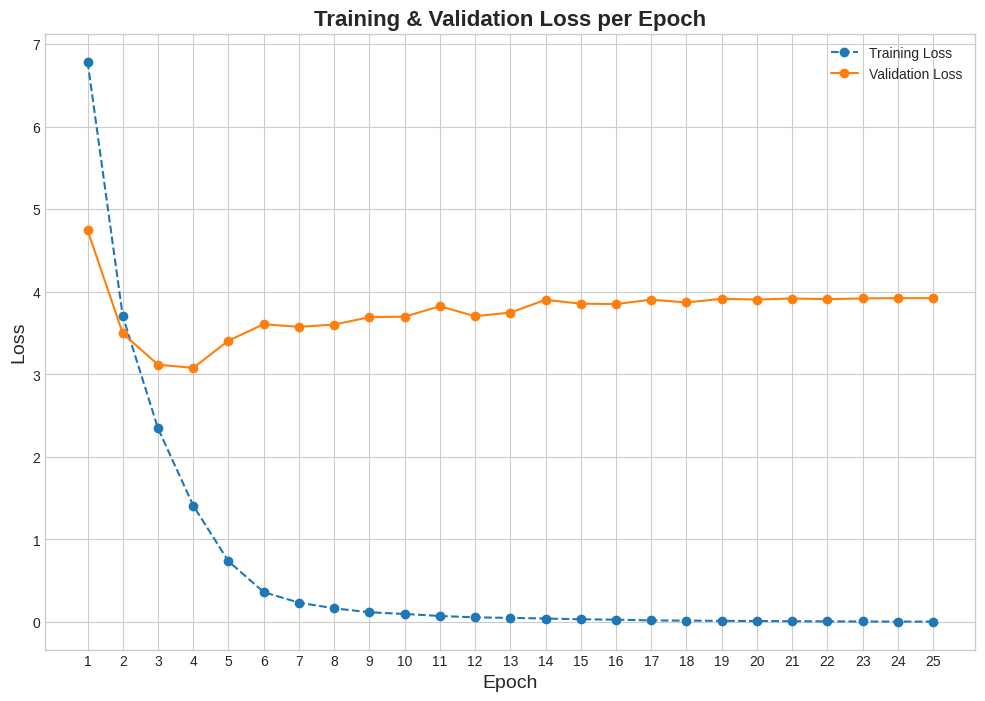

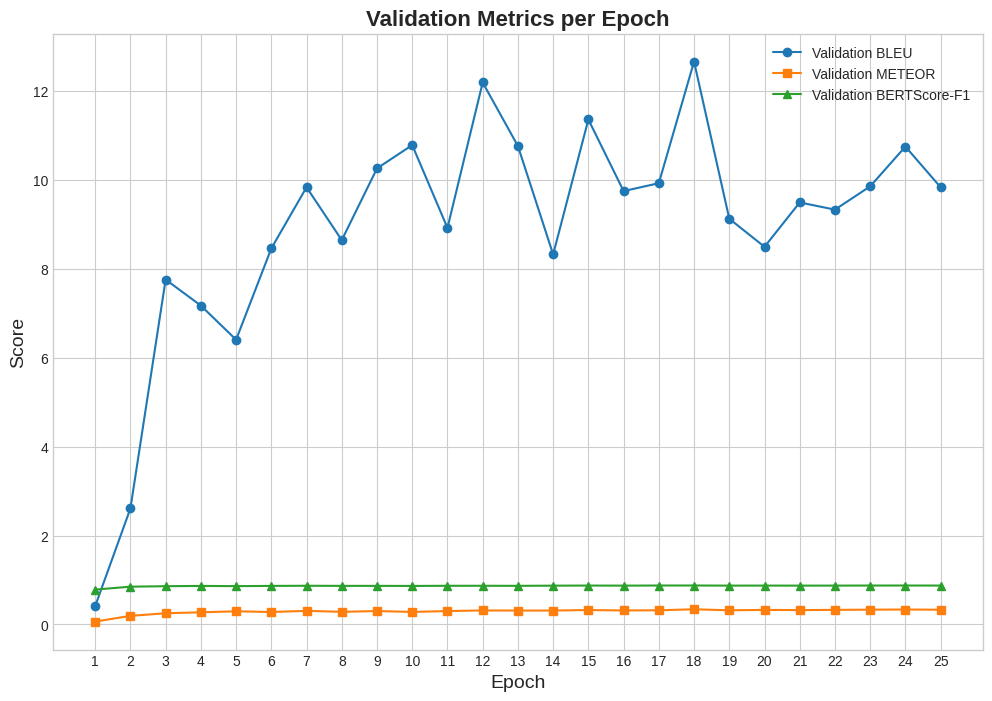


[INFO] Performing final evaluation on the test set...



--- Test Set Evaluation Results ---
Loss           : 3.8905
Bleu           : 18.3602
Meteor         : 0.3217
Bertscore_f1   : 0.8794
Gen_len        : 13.3519
Runtime        : 16.2163
Samples_per_second: 9.9900
Steps_per_second: 1.2950
-----------------------------------

[INFO] Running inference on test samples for qualitative analysis...

--- Qualitative Analysis: Sample Translations ---

Sample #1
  - Source (EN):              I can't come.
  - Reference (Romanized CCP):  Mui ei noparim
  - Model Output (Romanized CCP): Mui ebar chas
--------------------------------------------------
Sample #2
  - Source (EN):              There are many fish in this lake
  - Reference (Romanized CCP):  Ei hrodtanot balokkun maj age
  - Model Output (Romanized CCP): Ei lake aan hono maas aage
--------------------------------------------------
Sample #3
  - Source (EN):              Can you help me with my history project?
  - Reference (Romanized CCP):  Tui hi more itihash prokolpot shahajjo guri pa

In [ ]:
# =================================================================================================
# Kaggle Notebook: English to Romanized Chakma Translation with mBART-50
# =================================================================================================
#
# # 1. Setup and Installation
print("Installing necessary libraries...")
!pip install -q transformers[sentencepiece] datasets accelerate evaluate sacrebleu bert_score nltk
print("Installation complete.")
import pandas as pd
import numpy as np
import torch
import nltk
import re
import gc
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

from transformers import (
    MBartForConditionalGeneration,
    MBart50TokenizerFast,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import evaluate
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)

import os
import shutil

working_dir = "/kaggle/working"

if os.path.exists(working_dir):
    print(f"Cleaning Kaggle working directory: {working_dir}")
    for filename in os.listdir(working_dir):
        file_path = os.path.join(working_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}: {e}")
    print("Kaggle working directory cleaned!")


# # 2. Configuration
class Config:
    DATASET_PATH = "/kaggle/input/aacl-chakma/AACL - AACL_filtered.csv"
    SOURCE_LANG, TARGET_LANG = "English", "romanized chakma"
    
    MODEL_CHECKPOINT = "facebook/mbart-large-50-many-to-many-mmt"
    
    SOURCE_LANG_CODE, TARGET_LANG_CODE = "en_XX", "en_XX" 
    
    OUTPUT_DIR = "./mbart-eng-to-romanized-chakma"
    
    MAX_INPUT_LENGTH, MAX_TARGET_LENGTH = 128, 128
    BATCH_SIZE, GRADIENT_ACCUMULATION_STEPS = 8, 2
    EVAL_STRATEGY = "epoch"
    NUM_EPOCHS, LEARNING_RATE = 25, 5e-5
    WEIGHT_DECAY, WARMUP_STEPS = 0.01, 50
    TRAIN_RATIO, VALIDATION_RATIO, TEST_RATIO = 0.7, 0.1, 0.2
    SEED = 42

config = Config()
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


# # 3. Data Loading and Preprocessing
print("\n[INFO] Loading and preprocessing data for English -> Romanized Chakma...")
df = pd.read_csv(config.DATASET_PATH)
df = df[[config.SOURCE_LANG, config.TARGET_LANG]].rename(columns={config.SOURCE_LANG: 'en', config.TARGET_LANG: 'ccp'})
df.dropna(inplace=True)

def clean_text(text):
    return text.strip() if isinstance(text, str) else ""

df['en'] = df['en'].apply(clean_text)
df['ccp'] = df['ccp'].apply(clean_text) 
df = df[(df['en'] != '') & (df['ccp'] != '')]
print(f"Dataset loaded with {len(df)} samples after cleaning.")


# # 4. Train/Validation/Test Split
print("\n[INFO] Splitting the dataset...")
train_df, temp_df = train_test_split(df, test_size=(1 - config.TRAIN_RATIO), random_state=config.SEED)
val_df, test_df = train_test_split(temp_df, test_size=(config.TEST_RATIO / (config.VALIDATION_RATIO + config.TEST_RATIO)), random_state=config.SEED)
raw_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'validation': Dataset.from_pandas(val_df.reset_index(drop=True)),
    'test': Dataset.from_pandas(test_df.reset_index(drop=True))
})
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")


# # 5. Model and Tokenizer Initialization
print("\n[INFO] Initializing model and tokenizer...")
tokenizer = MBart50TokenizerFast.from_pretrained(
    config.MODEL_CHECKPOINT, 
    src_lang=config.SOURCE_LANG_CODE, 
    tgt_lang=config.TARGET_LANG_CODE
)
model = MBartForConditionalGeneration.from_pretrained(config.MODEL_CHECKPOINT)


# # 6. Tokenization
print("\n[INFO] Tokenizing datasets...")
def preprocess_function(examples):
    model_inputs = tokenizer(examples["en"], max_length=config.MAX_INPUT_LENGTH, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["ccp"], max_length=config.MAX_TARGET_LENGTH, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True, remove_columns=raw_datasets["train"].column_names)


# # 7. Evaluation Metrics
print("\n[INFO] Setting up evaluation metrics (BLEU, METEOR, BERTScore)...")
bleu_metric = evaluate.load("sacrebleu")
meteor_metric = evaluate.load("meteor")
bertscore_metric = evaluate.load("bertscore")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple): preds = preds[0]
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Post-processing for metrics
    post_processed_labels = [[label.strip()] for label in decoded_labels]
    post_processed_preds = [pred.strip() for pred in decoded_preds]
    
    bleu = bleu_metric.compute(predictions=post_processed_preds, references=post_processed_labels)
    meteor = meteor_metric.compute(predictions=post_processed_preds, references=post_processed_labels)
    
    bertscore = bertscore_metric.compute(predictions=post_processed_preds, references=post_processed_labels, lang="en")
    
    result = {
        "bleu": bleu["score"],
        "meteor": meteor["meteor"],
        "bertscore_f1": np.mean(bertscore["f1"]),
    }
    
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}


# # 8. Training Configuration
print("\n[INFO] Configuring training arguments...")
training_args = Seq2SeqTrainingArguments(
    output_dir=config.OUTPUT_DIR,
    eval_strategy=config.EVAL_STRATEGY,
    logging_strategy=config.EVAL_STRATEGY,
    save_strategy=config.EVAL_STRATEGY,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.BATCH_SIZE,
    learning_rate=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY,
    num_train_epochs=config.NUM_EPOCHS,
    warmup_steps=config.WARMUP_STEPS,
    fp16=True, 
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,
    gradient_checkpointing=True, 
    save_total_limit=1, 
    save_only_model=True, 
    predict_with_generate=True,
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
    report_to="none"    
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


# # 9. Model Training
gc.collect()
torch.cuda.empty_cache()
print("\n[INFO] Starting model training...")
train_result = trainer.train()
print("\n[INFO] Training finished.")

trainer.save_model(f"{config.OUTPUT_DIR}/best_model")
tokenizer.save_pretrained(f"{config.OUTPUT_DIR}/best_model")
print(f"Best model saved to {config.OUTPUT_DIR}/best_model")


# # 10. Training and Validation Curve Visualization
print("\n[INFO] Generating training and validation curves...")
log_history = trainer.state.log_history

eval_logs = [log for log in log_history if 'eval_loss' in log]
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_df = pd.DataFrame(eval_logs)
train_df_logs = pd.DataFrame(train_logs)

eval_df['epoch'] = eval_df['epoch'].round()
train_df_logs['epoch'] = train_df_logs['epoch'].round()
log_df = pd.merge(train_df_logs, eval_df, on='epoch', how='inner').drop_duplicates(subset=['epoch'], keep='last')

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(log_df['epoch'], log_df['loss'], label='Training Loss', marker='o', linestyle='--')
plt.plot(log_df['epoch'], log_df['eval_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss per Epoch', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.xticks(log_df['epoch'].unique().astype(int))
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(log_df['epoch'], log_df['eval_bleu'], label='Validation BLEU', marker='o')
ax.plot(log_df['epoch'], log_df['eval_meteor'], label='Validation METEOR', marker='s')
ax.plot(log_df['epoch'], log_df['eval_bertscore_f1'], label='Validation BERTScore-F1', marker='^')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Validation Metrics per Epoch', fontsize=16, weight='bold')
ax.legend()
ax.set_xticks(log_df['epoch'].unique().astype(int))
ax.grid(True)
plt.show()


# # 11. Final Evaluation on Test Set
print("\n[INFO] Performing final evaluation on the test set...")
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print("\n--- Test Set Evaluation Results ---")
for key, value in test_results.items():
    if key.startswith("eval_"):
        print(f"{key.replace('eval_', '').capitalize():<15}: {value:.4f}")
print("-----------------------------------")


# # 12. Inference and Qualitative Analysis
print("\n[INFO] Running inference on test samples for qualitative analysis...")
model_path = f"{config.OUTPUT_DIR}/best_model"
tokenizer = MBart50TokenizerFast.from_pretrained(model_path)
model = MBartForConditionalGeneration.from_pretrained(model_path).to(device)

def translate(text):
    tokenizer.src_lang = config.SOURCE_LANG_CODE
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=config.MAX_INPUT_LENGTH).to(device)
    
    generated_tokens = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id[config.TARGET_LANG_CODE],
        max_length=config.MAX_TARGET_LENGTH,
        num_beams=5,
        early_stopping=True
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

print("\n--- Qualitative Analysis: Sample Translations ---\n")
for i in range(min(10, len(test_df))):
    sample = raw_datasets['test'][i]
    source, reference = sample['en'], sample['ccp']
    model_output = translate(source)
    
    print(f"Sample #{i+1}")
    print(f"  - Source (EN):              {source}")
    print(f"  - Reference (Romanized CCP):  {reference}")
    print(f"  - Model Output (Romanized CCP): {model_output}")
    print("-" * 50)

print("\nNotebook execution complete.")